In [2]:
import gym
from gym import spaces
import numpy as np
import networkx
import pandas as pd
import random
import itertools
import matplotlib.pyplot as plt

In [3]:
class mRubisCliffEnv(gym.Env):
    metadata = {"render_modes": ['human'], 'render_fps': 4}

    def __init__(self, render_mode=None, n_components=(4,8), matrix="mRubis_Transition_Matrix.csv", discrete=True):
        self.random = random.Random(None)
        if discrete:
            self.observation_space = spaces.MultiDiscrete([max(n_components)+1]*18)
        else:
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(18,), dtype=np.float32)
        self.action_space = spaces.Discrete(18)
        #self.action_space = spaces.Box(low=0, high=18, shape=(1,), dtype=np.int64)

        df = pd.read_csv(matrix, index_col="Unnamed: 0")
        df = df.drop("Total", axis=1)
        df = df.drop("Supervisor Component", axis=0)
        df = df.drop("Supervisor Component", axis=1)
        binary_matrix = df.to_numpy() > 0

        graph = networkx.from_numpy_array(binary_matrix, create_using=networkx.DiGraph)
        networkx.relabel_nodes(graph, {idx: c for idx, c in enumerate(df.columns)}, copy=False)

        self.graph = graph
        self.components = list(df.columns)
        self.n_components = n_components
        self.render_mode = render_mode
        
        if discrete:
            self.cliff_reward = -max(n_components)
            self.wrong_reward = -1
            self.generate_observation = self.generate_discrete_observation
        else:
            self.cliff_reward = -1000
            self.wrong_reward = -100
            self.generate_observation = self.generate_continuous_observation

    def step(self, action):
        reward, terminated = self.applyAction(action)

        observation = self.utilities

        terminated = (np.sum(self.utilities) == 0) or terminated
        truncated = False
        info = {
            'utillities': self.utilities,
            'failed components': self.failed_components
        }

        if self.render_mode == 'human':
            self._drawFrame(wrong_action = (reward == -100), action=action)

        #return observation, reward, terminated, truncated, info, terminated
        return observation, reward, terminated, info


    def reset(self, seed=None, options=None):
        if seed is not None:
            self.random = random.Random(seed)
        self.generate_observation()

        observation = self.utilities
        info = {
            'utillities': self.utilities,
            'failed components': self.failed_components
        }

        if self.render_mode == 'human':
            self._drawFrame()

        return observation

    def render(self):
        if self.render_mode == 'human':
            self._drawFrame()

    def close(self):
        pass

    def get_new_failed_componentes(self):
        n_components = self.random.randint(*self.n_components)
        origin = self.random.choice(self.components[:-1])
        fail_ranking = list(itertools.chain(*list(networkx.bfs_layers(self.graph, origin))))
        fail_ranking = fail_ranking[:n_components]
        root = fail_ranking[0]
        masked = fail_ranking[1]
        cascaded = fail_ranking[2:n_components]
        self.random.shuffle(cascaded)

        return root, masked, cascaded



    def generate_continuous_observation(self):
        root, masked, cascaded = self.get_new_failed_componentes()

        root_drop = self.random.random()*100 + 100
        masked_drop = self.random.random()*200 + root_drop + 5
        cascaded_drops = [self.random.random()*(masked_drop - root_drop - 2.5) + root_drop + 2.5 for _ in range(len(cascaded))]

        utilities = np.zeros(18)
        utilities[self.components.index(root)] = root_drop
        utilities[self.components.index(masked)] = masked_drop
        for cascaded_drop, cascaded_component in zip(cascaded_drops, cascaded):
            utilities[self.components.index(cascaded_component)] = cascaded_drop

        self.utilities = utilities
        self.failed_components = [root] + [masked] + cascaded

    def generate_discrete_observation(self):
        root, masked, cascaded = self.get_new_failed_componentes()

        root_drop = 1
        masked_drop = len(cascaded)+2
        cascaded_drops = list(range(2,len(cascaded)+2))

        utilities = np.zeros(18, dtype=int)
        utilities[self.components.index(root)] = root_drop
        utilities[self.components.index(masked)] = masked_drop
        for cascaded_drop, cascaded_component in zip(cascaded_drops, cascaded):
            utilities[self.components.index(cascaded_component)] = cascaded_drop

        self.utilities = utilities
        self.failed_components = [root] + [masked] + cascaded


    def isAllowed(self, action):
        return self.utilities[action] != 0

    def applyAction(self, action):
        if not self.isAllowed(action):
            return self.wrong_reward, False
        if self.components[action] == self.failed_components[0]:
            reward = self.utilities[action] #+ self.utilities[self.components.index(self.failed_components[1])]
            self.utilities[action] = 0
            self.utilities[self.components.index(self.failed_components[1])] = 0
            return reward, False
        elif self.components[action] == self.failed_components[1]:
            return self.cliff_reward, True
        else:
            reward = self.utilities[action]
            self.utilities[action] = 0
            return reward, False

    def _drawFrame(self, action=None, wrong_action=False):
        plt.clf()
        colors = []
        for component in self.failed_components:
            if self.utilities[self.components.index(component)] == 0:
                if self.failed_components[0] == component:
                    colors.append((145/255, 219/255, 145/255)) #light green
                elif self.failed_components[1] == component:
                    colors.append((11/255, 84/255, 11/255)) #dark green
                else:
                    colors.append('green')
            else:
                if self.failed_components[0] == component:
                    colors.append((230/255, 148/255, 32/255)) #orange
                elif self.failed_components[1] == component:
                    colors.append((107/255, 20/255, 20/255)) #dark red
                else:
                    colors.append((230/255, 32/255, 32/255)) #red
        if wrong_action:
            plt.text(0.5,0.5, "wrong")
        subgraph = self.graph.subgraph(self.failed_components)    
        networkx.draw_circular(subgraph, node_color=colors, with_labels=True)



In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

env = mRubisCliffEnv(render_mode=None, discrete=False)
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=int(100000), progress_bar=True)

In [6]:
# Evaluate
import time
import tqdm
from stable_baselines3.common.callbacks import BaseCallback

def evaluate_callback(model, env, num_eval_steps=1000, eval_interval=10000, plot_progress=False):
    total_rewards = []
    if plot_progress:
        ax = plt.gca()

    def evaluate(*_args,**_kwargs):
        global total_steps
        if total_steps % eval_interval == 0:  
            env.render_mode = None
            obs = env.reset()
            rewards = []
            for i in range(num_eval_steps):
                action, _states = model.predict(obs)
                obs, reward, dones, info = env.step(action)
                rewards.append(reward)
                if dones:
                    obs = env.reset()
            total_rewards.append(np.mean(rewards))
            if plot_progress:
                ax.cla()
                ax.plot(rewards)
                plt.draw()
        total_steps += 1

    return evaluate, rewards

from IPython import display
class Evaluator(BaseCallback):
    def __init__(self, model, env, num_eval_steps=1000, eval_interval=10000, plot_progress=False):
        super().__init__()
        self.total_rewards = []
        self.model = model
        self.env = env
        self.num_eval_steps = num_eval_steps
        self.eval_interval = eval_interval
        self.plot_progress = plot_progress
        self.current_step = 0

    def _on_step(self):
        if self.current_step % self.eval_interval == 0:  
            self.env.render_mode = None
            obs = self.env.reset()
            rewards = []
            for i in range(self.num_eval_steps):
                action, _states = self.model.predict(obs)
                obs, reward, dones, info = self.env.step(action)
                rewards.append(reward)
                if dones:
                    obs = self.env.reset()
            self.total_rewards.append(np.mean(rewards))

            if self.plot_progress:
                display.clear_output(wait=True)
                fig = plt.figure(figsize=(10,5))
                plt.plot(self.total_rewards)
                plt.title(model.__class__.__name__)
                plt.xlabel("Training step")
                plt.ylabel("Average reward")
                display.display(fig)
        self.current_step += 1
        return True


In [ ]:
env.render_mode = 'human'
obs = env.reset()

for i in range(100):
    plt.clf()

    action, _states = model.predict(obs)
    obs, reward, dones, info = env.step(action)
    print(reward)

    plt.show()
    if dones:
        break

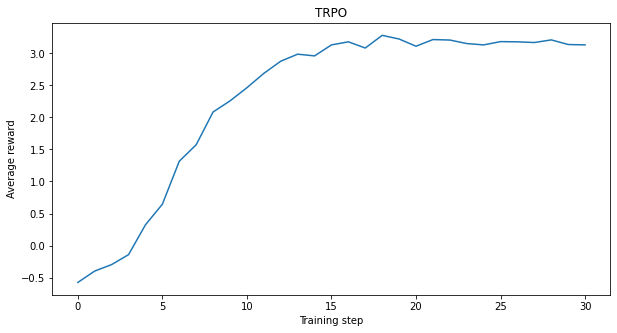

ValueError: Environment does not support action masking. Consider using ActionMasker wrapper

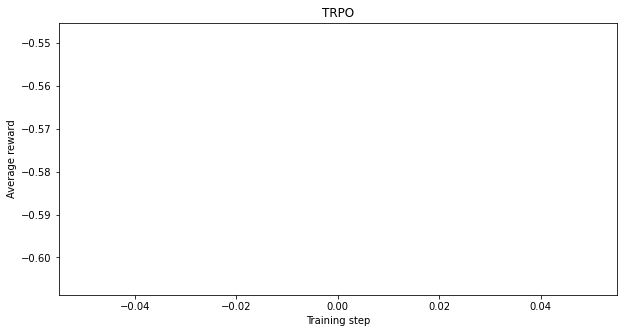

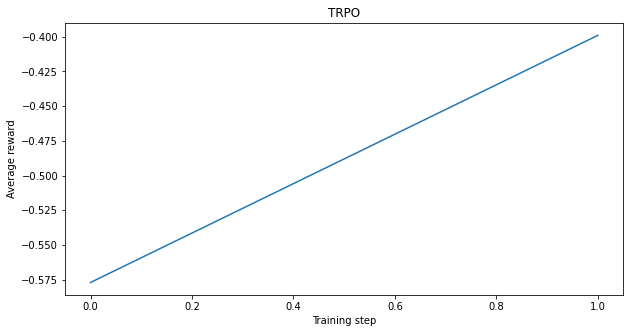

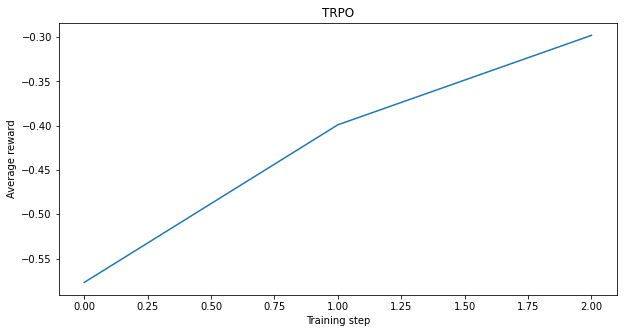

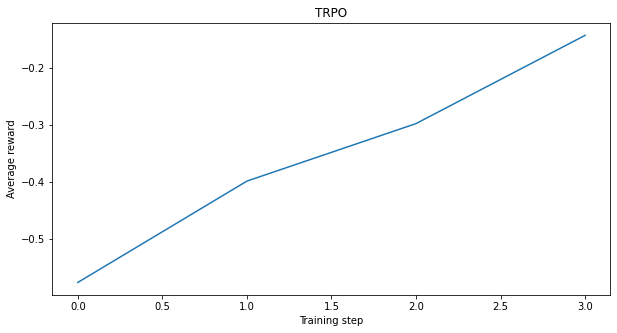

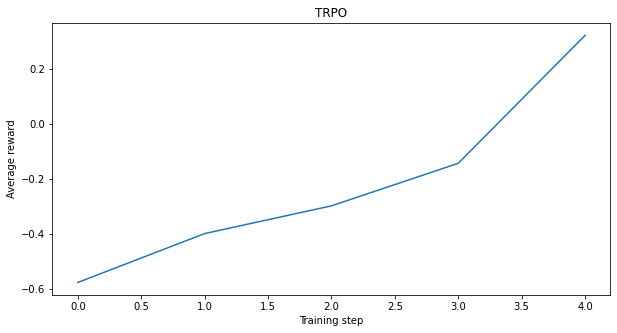

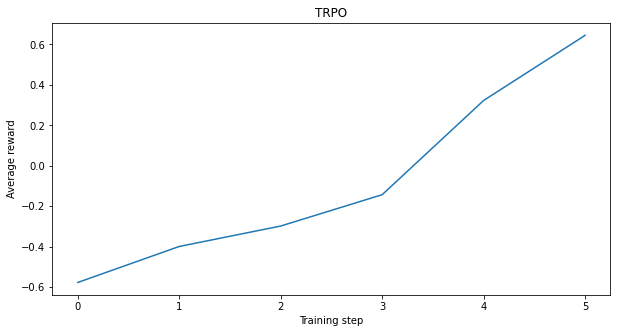

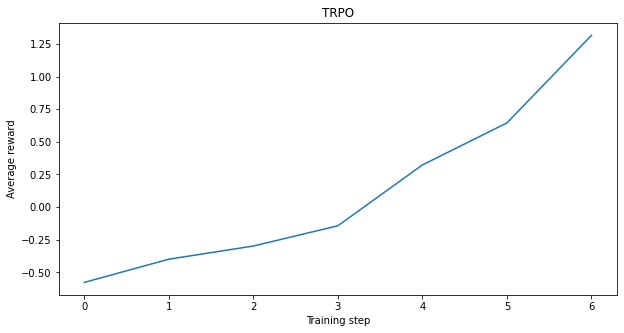

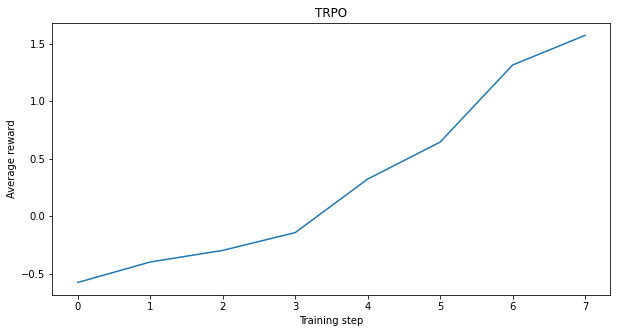

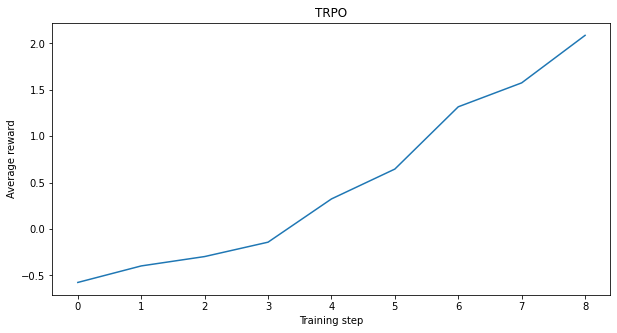

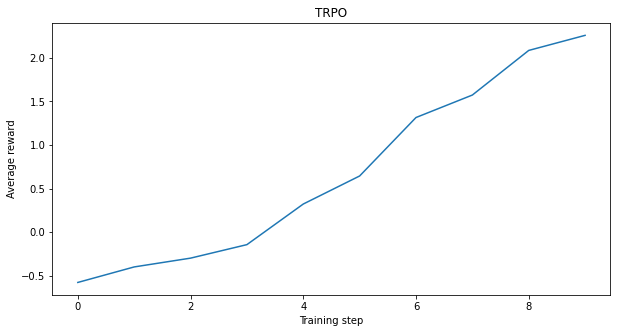

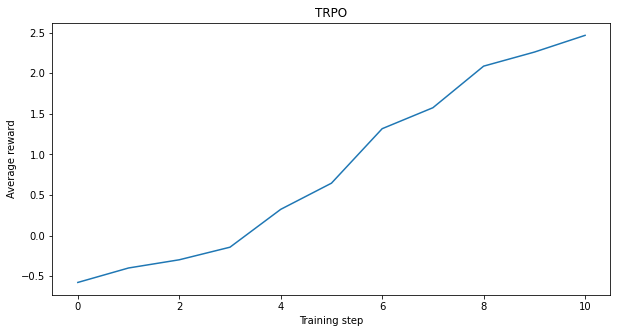

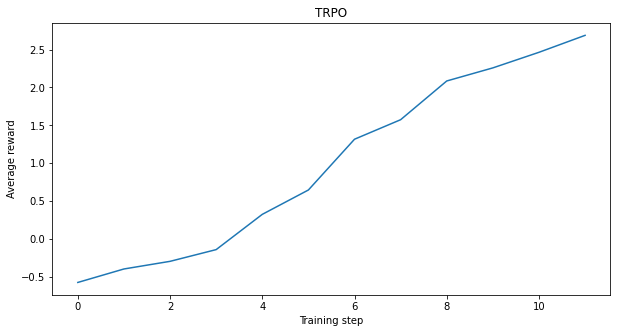

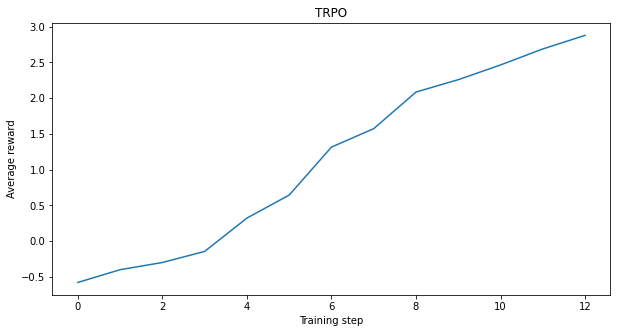

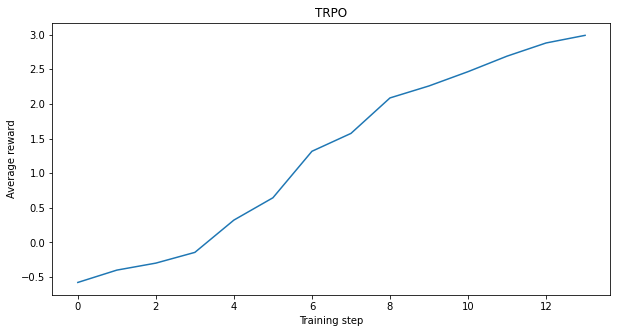

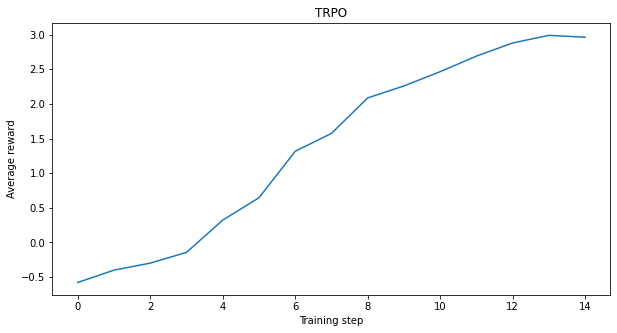

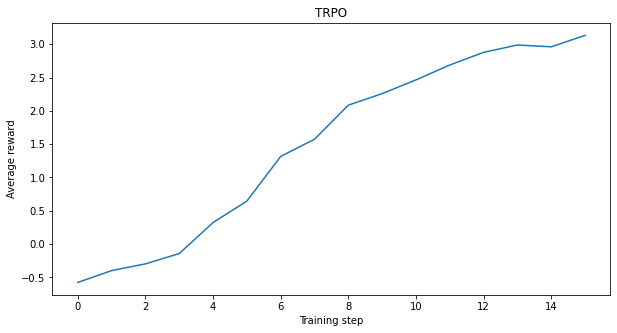

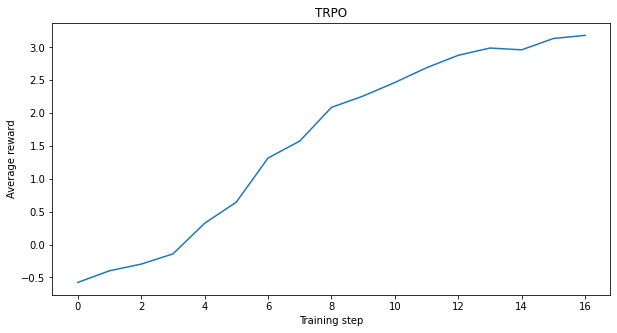

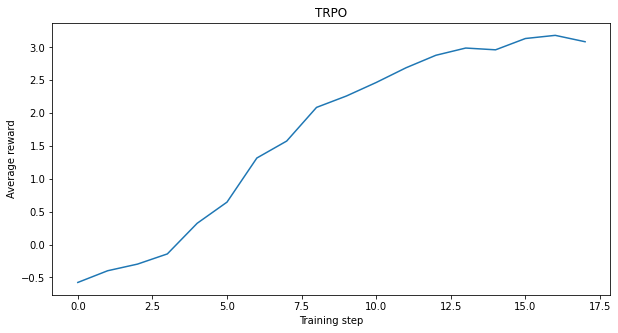

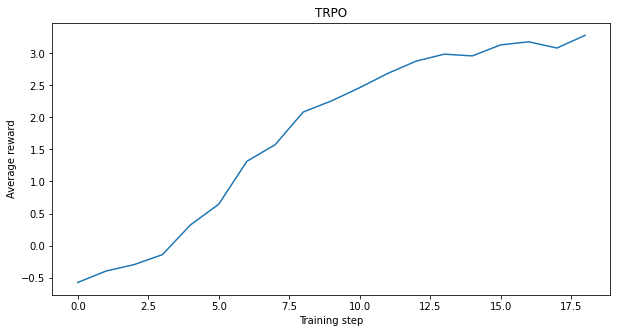

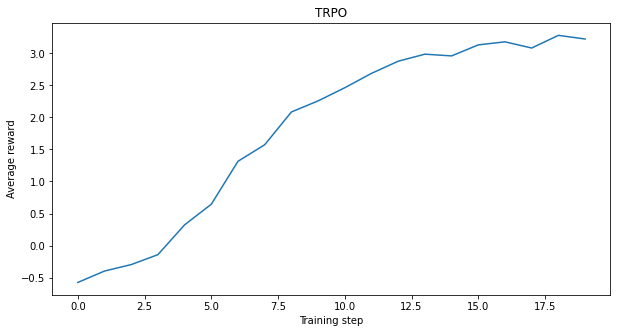

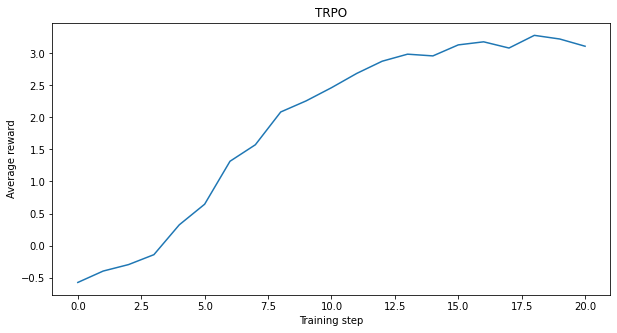

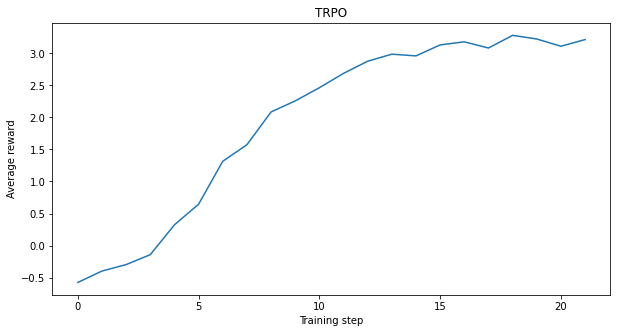

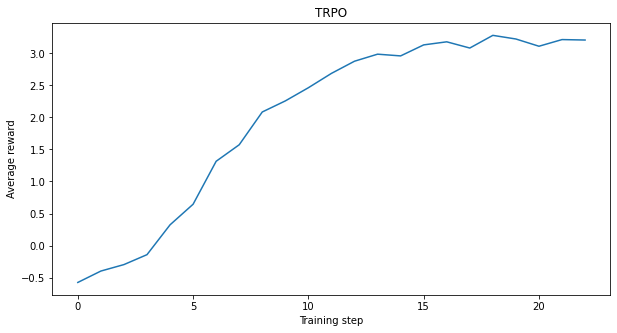

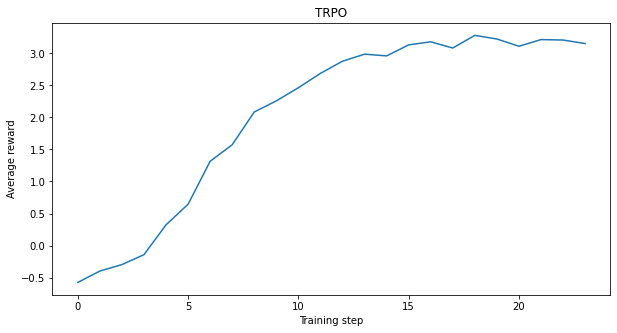

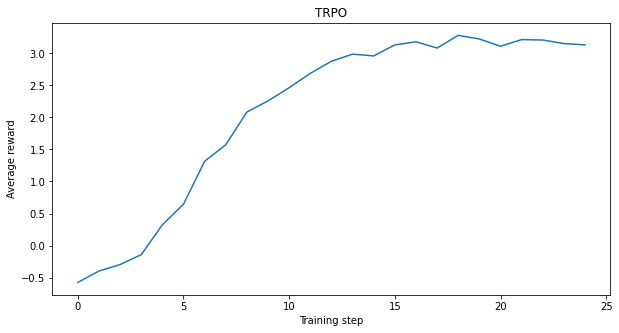

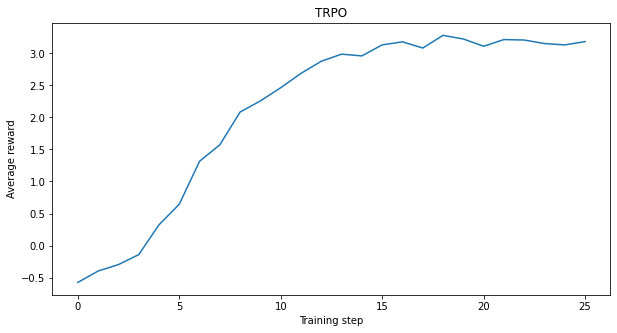

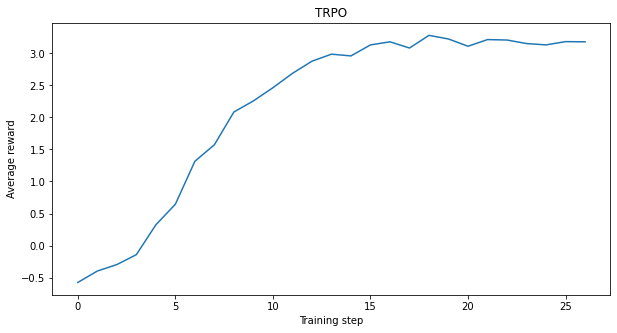

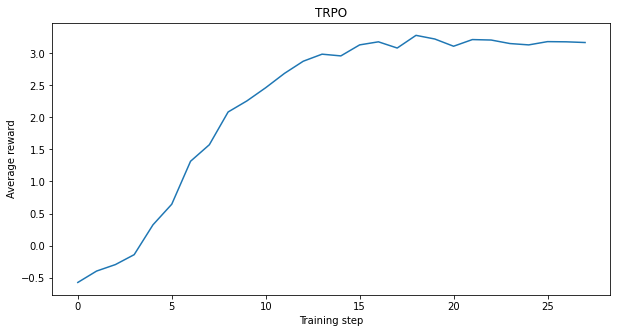

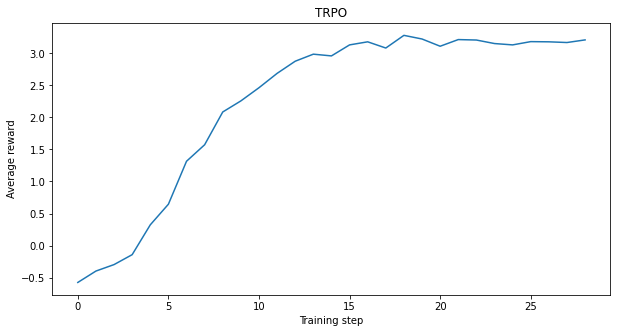

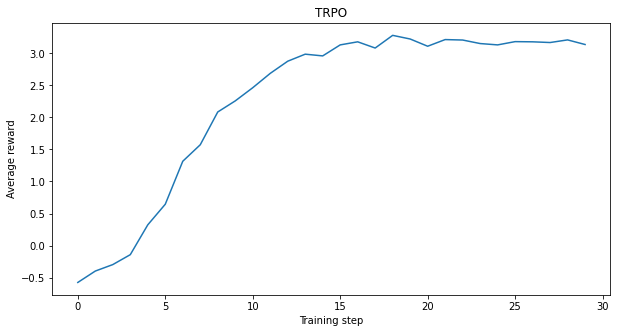

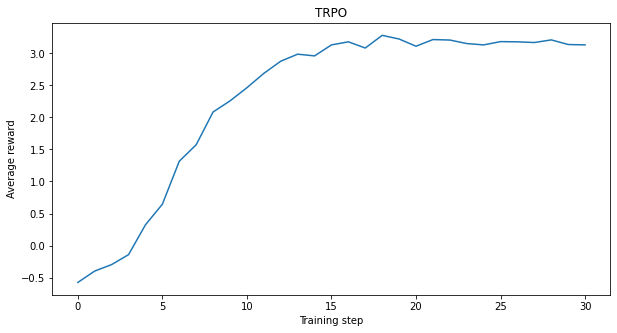

In [7]:
from stable_baselines3 import DQN, A2C, PPO
from sb3_contrib import ARS, TRPO

num_epochs = 30
models = [DQN, A2C, PPO, ARS, TRPO]
for model_class in models:
    env = mRubisCliffEnv(render_mode=None, discrete=True)
    model = model_class('MlpPolicy', env)
    evaluator = Evaluator(model, env, plot_progress=True)
    model.learn(total_timesteps=int(10000*num_epochs), callback=evaluator)
    plt.savefig("results/"+model.__class__.__name__+".png", dpi=600)



In [ ]:
from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy

%matplotlib inline

total_steps = 0

env = mRubisCliffEnv(render_mode=None, discrete=True)
model = A2C("MlpPolicy", env)
num_epochs = 10
rewards = []
evaluator = Evaluator(model, env, plot_progress=True)
model.learn(total_timesteps=int(10000*num_epochs), callback=evaluator)


In [ ]:
env.render_mode = 'human'
obs = env.reset()

for i in range(100):
    plt.clf()

    action, _states = model.predict(obs)
    obs, reward, dones, info = env.step(action)
    print(reward)

    plt.show()
    if dones:
        break